In [1]:
import os
import shutil
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import trax
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import fastmath
from utils import Layer, load_tweets, process_tweet
import warnings
warnings.filterwarnings('ignore')

/Users/vuhan/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/vuhan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vuhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Import and Preprocessing the Data

## 1.1 Loading data

In [2]:
def train_val_split():
    all_pos_tws, all_neg_tws = load_tweets()
    
    print(f"The number of positive tweets: {len(all_pos_tws)}")
    print(f"The number of negative tweets: {len(all_neg_tws)}")

    val_pos = all_pos_tws[4000: ]
    train_pos = all_pos_tws[: 4000]
    
    val_neg = all_neg_tws[4000: ]
    train_neg = all_neg_tws[: 4000]
    
    train_x = train_pos + train_neg
    val_x = val_pos + val_neg
    
    train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
    val_y = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))
    
    return train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y

In [3]:
train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y = train_val_split()

The number of positive tweets: 5000
The number of negative tweets: 5000


In [4]:
print('Length of train_x: {}'.format(len(train_x)))
print('Length of val_x: {}'.format(len(val_x)))

Length of train_x: 8000
Length of val_x: 2000


## 1.2 Building the Vocabulary

In [5]:
def get_vocab(data):
    
    Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}
    
    for tweet in data:
        processed_tweet = process_tweet(tweet)
        for word in processed_tweet:
            if word not in Vocab:
                Vocab[word] = len(Vocab)
    return Vocab

In [6]:
Vocab = get_vocab(train_x)

In [7]:
print('Total words in vocab: {}'.format(len(Vocab)))

Total words in vocab: 9088


In [8]:
Vocab

{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'followfriday': 3,
 'top': 4,
 'engag': 5,
 'member': 6,
 'commun': 7,
 'week': 8,
 ':)': 9,
 'hey': 10,
 'jame': 11,
 'odd': 12,
 ':/': 13,
 'pleas': 14,
 'call': 15,
 'contact': 16,
 'centr': 17,
 '02392441234': 18,
 'abl': 19,
 'assist': 20,
 'mani': 21,
 'thank': 22,
 'listen': 23,
 'last': 24,
 'night': 25,
 'bleed': 26,
 'amaz': 27,
 'track': 28,
 'scotland': 29,
 'congrat': 30,
 'yeaaah': 31,
 'yipppi': 32,
 'accnt': 33,
 'verifi': 34,
 'rqst': 35,
 'succeed': 36,
 'got': 37,
 'blue': 38,
 'tick': 39,
 'mark': 40,
 'fb': 41,
 'profil': 42,
 '15': 43,
 'day': 44,
 'one': 45,
 'irresist': 46,
 'flipkartfashionfriday': 47,
 'like': 48,
 'keep': 49,
 'love': 50,
 'custom': 51,
 'wait': 52,
 'long': 53,
 'hope': 54,
 'enjoy': 55,
 'happi': 56,
 'friday': 57,
 'lwwf': 58,
 'second': 59,
 'thought': 60,
 '’': 61,
 'enough': 62,
 'time': 63,
 'dd': 64,
 'new': 65,
 'short': 66,
 'enter': 67,
 'system': 68,
 'sheep': 69,
 'must': 70,
 'buy':

## 1.3 Converting a tweet to a Tensor

In [9]:
def tweet_to_tensor(tweet, vocab_dict, unk_token='__UNK__', verbose=False):
    '''
    Input: 
        tweet - A string containing a tweet
        vocab_dict - The words dictionary
        unk_token - The special string for unknown tokens
        verbose - Print info durign runtime
    Output:
        tensor_lst - A python list with
        
    '''
    word_lst = process_tweet(tweet)
    
    if verbose:
        print('List of words from processed tweet:')
        print(word_lst)
    
    tensor_lst = []
    
    unk_ID = vocab_dict[unk_token]
    
    if verbose:
        print('The unique integer ID for the unk_token is {}'.format(unk_ID))
        
    for word in word_lst:
        word_ID = vocab_dict[word] if word in vocab_dict else unk_ID
        tensor_lst.append(word_ID)
        
    return tensor_lst

In [10]:
tmp_twt = val_pos[1]

print('Actual tweet: {}'.format(tmp_twt))
print('\nTensor of tweet: {}'.format(tweet_to_tensor(tmp_twt, Vocab)))

Actual tweet: @heyclaireee is back! thnx God!!! i'm so happy :)

Tensor of tweet: [443, 2, 303, 566, 56, 9]


## 1.4 Creating a Batch Generator

In [11]:
def data_generator(data_pos, data_neg, batch_size, vocab_dict, loop, shuffle=False):
    '''
    Input: 
        data_pos - Set of positive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - A numpy array specifying the importance of each example
        
    '''
    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples
    assert batch_size % 2 == 0
    
    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2
    
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
    
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))
    
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)
    
    stop = False
    
    while not stop:
        batch = []
        
        for i in range(n_to_take):
            if pos_index >= len_data_pos:
                if not loop:
                    stop = True
                    break
                
                pos_index = 0
                
                if shuffle:
                    rnd.shuffle(pos_index_lines)
                    
            tweet = data_pos[pos_index_lines[pos_index]]
            tensor = tweet_to_tensor(tweet, vocab_dict)
            batch.append(tensor)
            pos_index += 1
        
        for i in range(n_to_take):
            if neg_index >= len_data_neg:
                if not loop:
                    stop = True
                    break
                    
                neg_index = 0
                
                if shuffle:
                    rnd.shuffle(neg_index_lines)
                    
            tweet = data_neg[neg_index_lines[neg_index]]
            tensor = tweet_to_tensor(tweet, vocab_dict)
            batch.append(tensor)
            neg_index += 1
            
        if stop:
            break;
        
        max_len = max([len(t) for t in batch])
        
        tensor_pad_lst = []
        
        for tensor in batch:
            n_pad = max_len - len(tensor)
            pad_lst = [0] * n_pad
            tensor_pad = tensor + pad_lst
            tensor_pad_lst.append(tensor_pad)
        
        inputs = np.array(tensor_pad_lst)
        target_pos = [1] * n_to_take
        target_neg = [0] * n_to_take
        target_lst = target_pos + target_neg
        targets = np.array(target_lst)
        example_weights = np.ones_like(targets)
        
        yield inputs, targets, example_weights

In [12]:
rnd.seed(30)

def train_generator(train_pos, train_neg, batch_size, vocab_dict, loop=True, shuffle=False):
    return data_generator(train_pos, train_neg, batch_size, vocab_dict, loop, shuffle)

inputs, targets, example_weights = next(train_generator(train_pos, train_neg, 6, Vocab, shuffle=True))

print('Inputs: {}'.format(inputs))
print('\nTargets: {}'.format(targets))
print('\nExample Weights: {}'.format(example_weights))

Inputs: [[2005 4450 3200    9    0    0    0    0    0    0    0]
 [4953  566 2000 1453 5173 3498  141 3498  130  458    9]
 [ 566 4848   92  353   45    9    0    0    0    0    0]
 [3760  109  136  582 2929 3968    0    0    0    0    0]
 [ 249 3760    0    0    0    0    0    0    0    0    0]
 [3820 7152 3760    0    0    0    0    0    0    0    0]]

Targets: [1 1 1 0 0 0]

Example Weights: [1 1 1 1 1 1]


In [13]:
def val_generator(val_pos, val_neg, batch_size, vocab_dict, loop=True, shuffle=False):
    return data_generator(val_pos, val_neg, batch_size, vocab_dict, loop, shuffle)

def test_generator(val_pos, val_neg, batch_size, vocab_dict, loop=False, shuffle=False):
    return data_generator(val_pos, val_neg, batch_size, vocab_dict, loop, shuffle)

# 2. Defining Classes

In [14]:
class Layer(object):
    def __init__(self):
        self.weights = None
        
    def forward(self, x):
        raise NotImplementedError
        
    def init_weights_and_state(self, input_signature, random_key):
        pass
    
    def init(self, input_signature, random_key):
        self.init_weights_and_state(input_signature, random_key)
        return self.weights
    
    def __call__(self, x):
        return self.forward(x)

## 2.1 ReLU Class

In [15]:
class Relu(Layer):
    def forward(self, x):
        activation = np.maximum(x, 0)
        
        return activation

In [16]:
x = np.array([[-2, -1, 0], [0, 1, 2]])

relu_layer = Relu()

print('Original data:')
print(x)
print('Output of Relu:')
print(relu_layer(x))

Original data:
[[-2 -1  0]
 [ 0  1  2]]
Output of Relu:
[[0 0 0]
 [0 1 2]]


## 2.2 Dense Class

In [17]:
class Dense(Layer):
    def __init__(self, n_units, init_stdev=0.1):
        self._n_units = n_units
        self._init_stdev = init_stdev
        
    def forward(self, x):
        dense = np.dot(x, self.weights)
        return dense
    
    def init_weights_and_state(self, input_signature, random_key):
        input_shape = input_signature.shape
        w = self._init_stdev * trax.fastmath.random.normal(key = random_key,
                                                           shape = (input_shape[1], self._n_units),
                                                           )
        self.weights = w
        
        return self.weights

In [18]:
dense_layer = Dense(n_units=10)
random_key = trax.fastmath.random.get_prng(seed=0)
z = np.array([[2, 7, 25]])

dense_layer.init(z, random_key)

print('Weights are:\n{}'.format(dense_layer.weights))

Weights are:
[[-0.02837107  0.09368163 -0.10050073  0.14165013  0.10543301  0.09108127
  -0.04265671  0.0986188  -0.05575324  0.0015325 ]
 [-0.2078568   0.05548371  0.09142365  0.05744596  0.07227863  0.01210618
  -0.03237354  0.16234998  0.02450039 -0.13809781]
 [-0.06111237  0.01403725  0.08410043 -0.10943579 -0.1077502  -0.11396457
  -0.0593338  -0.01557651 -0.03832145 -0.11144515]]


In [19]:
print('Forward function output is: \n{}'.format(dense_layer(z)))

Forward function output is: 
[[-3.0395489   0.9266805   2.5414748  -2.0504727  -1.9769386  -2.5822086
  -1.7952733   0.94427466 -0.89803994 -3.7497485 ]]


## 2.3 Model

In [20]:
rnd.seed(31)
exp_embed = tl.Embedding(d_feature=2, vocab_size=3)
display(exp_embed)

Embedding_3_2

In [21]:
arr = np.array([[0, 1, 2], [3, 0, 2]])

exp_embed.init(trax.shapes.signature(arr))

(DeviceArray([[-0.09254155,  1.1765094 ],
              [ 1.0511576 ,  0.7154667 ],
              [ 0.7439485 , -0.81590366]], dtype=float32),
 ())

In [22]:
exp_embed_arr = exp_embed(arr)
exp_embed_arr

DeviceArray([[[-0.09254155,  1.1765094 ],
              [ 1.0511576 ,  0.7154667 ],
              [ 0.7439485 , -0.81590366]],

             [[ 0.7439485 , -0.81590366],
              [-0.09254155,  1.1765094 ],
              [ 0.7439485 , -0.81590366]]], dtype=float32)

In [23]:
exp_embed_arr.shape

(2, 3, 2)

In [24]:
tmp_embeded = np.array([[1,2],
                        [3,4],
                        [5,6]])

# take the mean along axis 0
print("The mean along axis 0 creates a vector whose length equals the number of features in a word embedding")
display(np.mean(tmp_embeded,axis=0))

print("The mean along axis 1 creates a vector whose length equals the number of words in a sentence")
display(np.mean(tmp_embeded,axis=1))

The mean along axis 0 creates a vector whose length equals the number of features in a word embedding


DeviceArray([3., 4.], dtype=float32)

The mean along axis 1 creates a vector whose length equals the number of words in a sentence


DeviceArray([1.5, 3.5, 5.5], dtype=float32)

In [25]:
def classifier(vocab_size=9088, embedding_dim=256, output_dim=2, mode='train'):
    
    embed_layer = tl.Embedding(vocab_size=vocab_size, d_feature=embedding_dim)
    
    mean_layer = tl.Mean(axis=1)
    
    dense_output_layer = tl.Dense(n_units = output_dim)
    
    log_softmax_layer = tl.LogSoftmax()
    
    model = tl.Serial(embed_layer,
                      mean_layer,
                      dense_output_layer,
                      log_softmax_layer)
    return model

In [26]:
exp_model = classifier(vocab_size=len(Vocab))

exp_model

Serial[
  Embedding_9088_256
  Mean
  Dense_2
  LogSoftmax
]

# 3. Training

## 3.1 Training the Model

In [27]:
from trax.supervised import training

def get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, vocab_dict, loop, batch_size=16):
    
    rnd.seed(271)
    
    train_task = training.TrainTask(
        labeled_data = train_generator(train_pos, train_neg, batch_size, vocab_dict, loop, shuffle=True),
        loss_layer = tl.WeightedCategoryCrossEntropy(),
        optimizer = trax.optimizers.Adam(0.01),
        n_steps_per_checkpoint=10)
    
    eval_task = training.EvalTask(
        labeled_data = val_generator(val_pos, val_neg, batch_size, vocab_dict, loop, shuffle=True),
        metrics = [tl.WeightedCategoryCrossEntropy(), tl.WeightedCategoryAccuracy()])
    
    return train_task, eval_task

In [28]:
train_task, eval_task = get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, 
                                             Vocab, loop=True, batch_size=16)

In [29]:
model = classifier()

In [30]:
dir_path = './model/'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    pass

output_dir = './model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

./model/


In [31]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task. Received as a list.
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''
    rnd.seed(31)
    
    training_loop = training.Loop(classifier,
                                  train_task,
                                  eval_tasks = eval_task,
                                  output_dir = output_dir,
                                  random_seed=31
                                 )
    
    training_loop.run(n_steps = n_steps)
    
    return training_loop

In [32]:
training_loop = train_model(model, train_task, [eval_task], 100, output_dir_expand)


Step      1: Total number of trainable weights: 2327042
Step      1: Ran 1 train steps in 0.86 secs
Step      1: train WeightedCategoryCrossEntropy |  0.69147205
Step      1: eval  WeightedCategoryCrossEntropy |  0.69827205
Step      1: eval      WeightedCategoryAccuracy |  0.43750000

Step     10: Ran 9 train steps in 3.73 secs
Step     10: train WeightedCategoryCrossEntropy |  0.64355624
Step     10: eval  WeightedCategoryCrossEntropy |  0.53490156
Step     10: eval      WeightedCategoryAccuracy |  1.00000000

Step     20: Ran 10 train steps in 1.46 secs
Step     20: train WeightedCategoryCrossEntropy |  0.45552301
Step     20: eval  WeightedCategoryCrossEntropy |  0.33445308
Step     20: eval      WeightedCategoryAccuracy |  1.00000000

Step     30: Ran 10 train steps in 1.17 secs
Step     30: train WeightedCategoryCrossEntropy |  0.24172144
Step     30: eval  WeightedCategoryCrossEntropy |  0.15988171
Step     30: eval      WeightedCategoryAccuracy |  1.00000000

Step     40: Ran 

## 3.2 Making a Prediction

In [33]:
tmp_train_generator = train_generator(train_pos, train_neg, 16, Vocab, loop=True, shuffle = False)

tmp_batch = next(tmp_train_generator)

tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

In [34]:
tmp_batch

(DeviceArray([[   3,    4,    5,    6,    7,    8,    9,    0,    0,    0,
                  0,    0,    0,    0,    0],
              [  10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
                 20,    9,   21,   22,    0],
              [  23,   24,   25,    9,   26,   27,   28,   29,    0,    0,
                  0,    0,    0,    0,    0],
              [  30,    9,    0,    0,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0],
              [  31,   32,   33,   34,   35,   36,   37,   38,   39,   40,
                 41,   42,    9,   43,   44],
              [  45,   46,    9,   47,    0,    0,    0,    0,    0,    0,
                  0,    0,    0,    0,    0],
              [  48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
                 58,    9,    0,    0,    0],
              [  59,   60,   61,   62,   63,   64,    9,   65,   66,   67,
                 68,   69,   70,   71,    0],
              [5736, 2900, 3760,

In [35]:
print(f"The batch is a tuple of length {len(tmp_batch)} because position 0 contains the tweets, and position 1 contains the targets.") 
print(f"\nThe shape of the tweet tensors is {tmp_inputs.shape} (num of examples, length of tweet tensors)")
print(f"\nThe shape of the labels is {tmp_targets.shape}, which is the batch size.")
print(f"\nThe shape of the example_weights is {tmp_example_weights.shape}, which is the same as inputs/targets size.")

The batch is a tuple of length 3 because position 0 contains the tweets, and position 1 contains the targets.

The shape of the tweet tensors is (16, 15) (num of examples, length of tweet tensors)

The shape of the labels is (16,), which is the batch size.

The shape of the example_weights is (16,), which is the same as inputs/targets size.


In [36]:
tmp_pred = training_loop.eval_model(tmp_inputs)

tmp_pred

DeviceArray([[-9.45541382e+00, -7.82012939e-05],
             [-7.91714096e+00, -3.64542007e-04],
             [-1.08034649e+01, -2.05039978e-05],
             [-7.28871250e+00, -6.83546066e-04],
             [-5.47317123e+00, -4.20665741e-03],
             [-8.18597984e+00, -2.78472900e-04],
             [-9.05854225e+00, -1.16348267e-04],
             [-7.35542679e+00, -6.39438629e-04],
             [-2.35319138e-03, -6.05316162e+00],
             [-2.82764435e-04, -8.17061806e+00],
             [-1.15513802e-03, -6.76408100e+00],
             [-1.90734863e-06, -1.31217785e+01],
             [-2.30731964e-02, -3.78059936e+00],
             [-5.58590889e-03, -5.19031191e+00],
             [-2.30097771e-03, -6.07555199e+00],
             [-1.73568726e-04, -8.65911102e+00]], dtype=float32)

In [37]:
tmp_is_positive = tmp_pred[:,1] > tmp_pred[:,0]

for i, p in enumerate(tmp_is_positive):
    print(f"Neg log prob {tmp_pred[i,0]:.4f}\tPos log prob {tmp_pred[i,1]:.4f}\t is positive? {p}\t actual {tmp_targets[i]}")

Neg log prob -9.4554	Pos log prob -0.0001	 is positive? True	 actual 1
Neg log prob -7.9171	Pos log prob -0.0004	 is positive? True	 actual 1
Neg log prob -10.8035	Pos log prob -0.0000	 is positive? True	 actual 1
Neg log prob -7.2887	Pos log prob -0.0007	 is positive? True	 actual 1
Neg log prob -5.4732	Pos log prob -0.0042	 is positive? True	 actual 1
Neg log prob -8.1860	Pos log prob -0.0003	 is positive? True	 actual 1
Neg log prob -9.0585	Pos log prob -0.0001	 is positive? True	 actual 1
Neg log prob -7.3554	Pos log prob -0.0006	 is positive? True	 actual 1
Neg log prob -0.0024	Pos log prob -6.0532	 is positive? False	 actual 0
Neg log prob -0.0003	Pos log prob -8.1706	 is positive? False	 actual 0
Neg log prob -0.0012	Pos log prob -6.7641	 is positive? False	 actual 0
Neg log prob -0.0000	Pos log prob -13.1218	 is positive? False	 actual 0
Neg log prob -0.0231	Pos log prob -3.7806	 is positive? False	 actual 0
Neg log prob -0.0056	Pos log prob -5.1903	 is positive? False	 actual 

In [38]:
display(tmp_is_positive)

DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
             False, False, False, False, False, False, False, False],            dtype=bool)

In [39]:
tmp_is_positive_int = tmp_is_positive.astype(np.int32)

In [40]:
display(tmp_is_positive_int)

DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [41]:
tmp_is_positive_float = tmp_is_positive.astype(np.float32)
display(tmp_is_positive_float)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
             0.], dtype=float32)

# 4. Evaluation

## 4.1 Computing the Accuracy on a Batch

In [42]:
def compute_accuracy(preds, y, y_weights):
    """
    Input: 
        preds: a tensor of shape (dim_batch, output_dim) 
        y: a tensor of shape (dim_batch,) with the true labels
        y_weights: a n.ndarray with the a weight for each example
    Output: 
        accuracy: a float between 0-1 
        weighted_num_correct (np.float32): Sum of the weighted correct predictions
        sum_weights (np.float32): Sum of the weights
    """
    
    is_pos = preds[:, 1] > preds[:, 0]
    is_pos_int = is_pos.astype(np.int32)
    
    correct = is_pos_int == y
    
    sum_weights = np.sum(y_weights)
    
    correct_float = correct.astype(np.float32)
    
    weighted_correct_float = correct_float * y_weights
    weighted_num_correct = np.sum(weighted_correct_float)
    
    accuracy = weighted_num_correct / sum_weights
    
    return accuracy, weighted_num_correct, sum_weights

In [43]:
tmp_eval_generator = val_generator(val_pos, val_neg, 64, Vocab, loop=True, shuffle=True)

tmp_batch = next(tmp_eval_generator)

tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

tmp_pred = training_loop.eval_model(tmp_inputs)

tmp_acc, tmp_num_correct, tmp_num_predictions = compute_accuracy(preds=tmp_pred, 
                                                                 y=tmp_targets, 
                                                                 y_weights=tmp_example_weights)

In [44]:
print('Accuray of model in single training batch: {}%'.format(tmp_acc * 100))
print('\nWeighted number of correct predictions: {}'.format(tmp_num_correct))
print('\nWeighted number of total observations: {}'.format(tmp_num_predictions))

Accuray of model in single training batch: 100.0%

Weighted number of correct predictions: 64.0

Weighted number of total observations: 64


## 4.2 Testing on Validation data

In [45]:
def test_model(generator, model, compute_accuracy=compute_accuracy):
    '''
    Input: 
        generator: an iterator instance that provides batches of inputs and targets
        model: a model instance 
    Output: 
        accuracy: float corresponding to the accuracy
    '''
    accuracy = 0.
    total_num_correct = 0
    total_num_pred = 0
    
    for batch in generator:
        inputs = batch[0]
        targets = batch[1]
        example_weight = batch[2]
        
        pred = model(inputs)
        
        batch_acc, batch_num_correct, batch_num_pred = compute_accuracy(pred, targets, example_weight)
        
        total_num_correct += batch_num_correct
        total_num_pred += batch_num_pred
        
    accuracy = total_num_correct / total_num_pred
    
    return accuracy

In [46]:
model = training_loop.eval_model
accuracy = test_model(test_generator(val_pos, val_neg, 16, Vocab, loop=False, shuffle=False), model)

print('The accuracy of model in validation set: {:.4f}'.format(accuracy))

The accuracy of model in validation set: 0.9955


# 5. Testing with custome Inputs

In [47]:
def predict(sentence):
    
    inputs = np.array(tweet_to_tensor(sentence, vocab_dict=Vocab))
    inputs = inputs[None, :]
    
    preds_probs = model(inputs)
    preds = int(preds_probs[0, 1] > preds_probs[0, 0])
    
    sentiment = 'negative'
    
    if preds == 1:
        sentiment = 'positive'
        
    return preds, sentiment

In [48]:
sentence = "It's such a nice day, I think I'll be taking Sid to Ramsgate for lunch and then to the beach maybe."

print('Sentence: \n{}'.format(sentence))

tmp_pred, tmp_sentiment = predict(sentence)

print('\nThe sentence above is {}'.format(tmp_sentiment))

Sentence: 
It's such a nice day, I think I'll be taking Sid to Ramsgate for lunch and then to the beach maybe.

The sentence above is positive


In [49]:
sentence = "It's such a worst day!!! I didn't like this day!"

print('Sentence: \n{}'.format(sentence))

tmp_pred, tmp_sentiment = predict(sentence)

print('\nThe sentence above is {}'.format(tmp_sentiment))

Sentence: 
It's such a worst day!!! I didn't like this day!

The sentence above is negative


# 6. Words Embedding

In [50]:
embeddings = model.weights[0]

embeddings.shape

(9088, 256)

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

embed_reduced = pca.fit_transform(embeddings)

In [52]:
neg_words = ['worst', 'bad', 'hurt', 'sad', 'hate']
pos_words = ['best', 'good', 'nice', 'better', 'love']

pos_n = [Vocab[w] for w in pos_words]
neg_n = [Vocab[w] for w in neg_words]

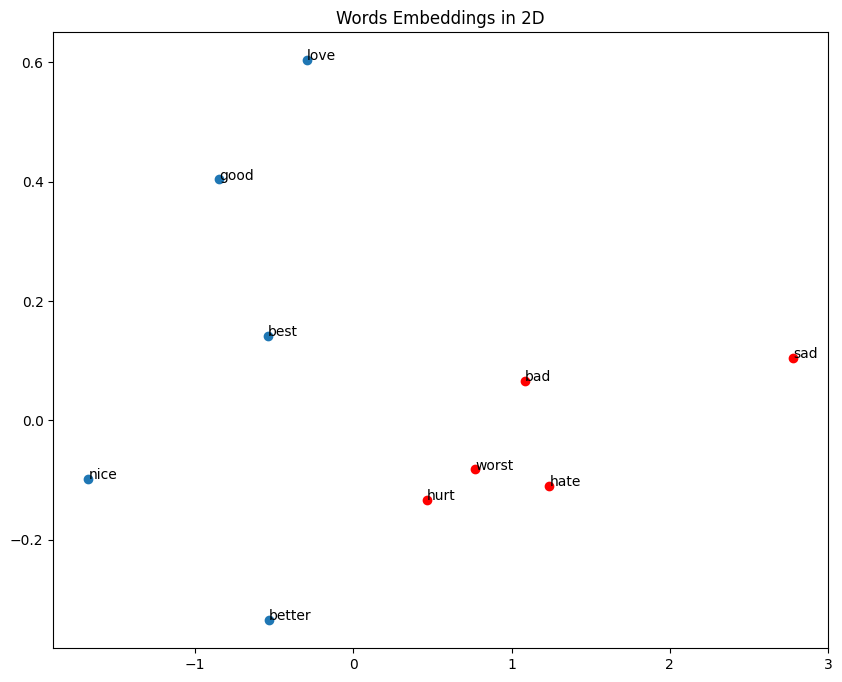

In [53]:
%matplotlib inline
plt.figure(figsize=(10, 8))

plt.scatter(embed_reduced[neg_n][:, 0], embed_reduced[neg_n][:, 1], color='r')
for i, t in enumerate(neg_words):
    plt.annotate(t, (embed_reduced[neg_n][i, 0], embed_reduced[neg_n][i, 1]))
    
plt.scatter(embed_reduced[pos_n][:, 0], embed_reduced[pos_n][:, 1])
for i, t in enumerate(pos_words):
    plt.annotate(t, (embed_reduced[pos_n][i, 0], embed_reduced[pos_n][i, 1]))

plt.title('Words Embeddings in 2D')
plt.show()